<a href="https://colab.research.google.com/github/Aidzillafont/Insurance-Claim-Fraud-Detection/blob/main/Insurance_Claim_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Goal

The objective here is to explore an insurance claims dataset taken from [Kaggle](https://www.kaggle.com/datasets/buntyshah/auto-insurance-claims-data)

We will start by exploring the data visually, then set up some preprocessing and finally create 3 models to try to predict if claims are fraudulent.

#Data Exploration

In [1]:
import pandas as pd

df = pd.read_csv('https://github.com/Aidzillafont/Insurance-Claim-Fraud-Detection/blob/d64bc1795da80891dd522578e77a9007c6651eca/insurance_claims.csv?raw=true')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

As can be seen, _c39 all null items so we can remove this column.

In [3]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


Here we transform some of our date and time data into the correct data types and create numeric versions of that data to check correlations with other data.

In [4]:
df = df.astype({'policy_bind_date':'datetime64', 
           'incident_date':'datetime64',
           'incident_hour_of_the_day':'int64'})

df['policy_bind_date_num'] = pd.to_numeric(df['policy_bind_date'])
df['incident_date_num'] = pd.to_numeric(df['incident_date'])

df['fraud_binary'] = df['fraud_reported'].map(dict(Y=1, N=0))

In [5]:
#remove the column _c39 containing NAs
df = df.dropna(axis=1)

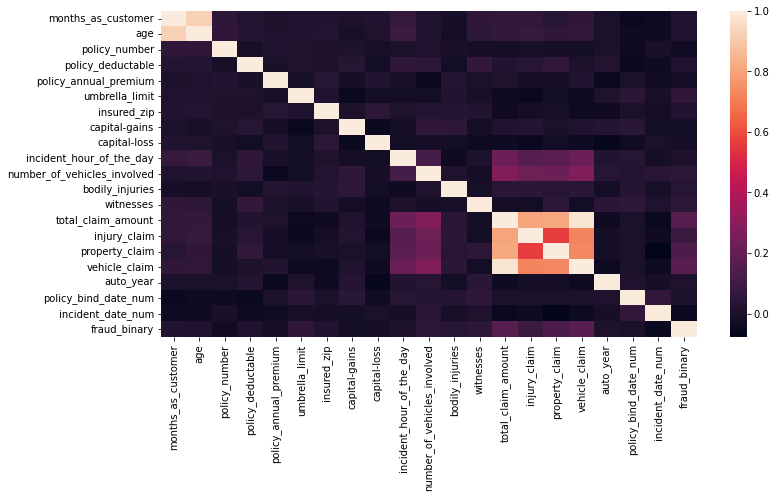

In [6]:
#Plot some correlations of numerical data
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr)
plt.show()

Here we can see a correlation between age and months as a customer, this suggests that older customers have been covered for longer

Total_claim_amount correlates with the values of injury/property and vehicle claims. Since these are functionally related, this is an expected result.

Vehicle claims are almost perfectly correlated, with total claim amount suggesting this is the most common type of claim. Since this data set pertains to auto insurance claims, this is an expected finding.

Let's check for potential features with very high correlation. We may want to remove these later since high correlated features (>0.9) introduce colinearity and increase the variability of the model prediction.

The varibles we may need to choose between are:
months_as_customer vs age (corr = 0.92)
total_claim_amount vs vehicle_claim (corr = 0.98)

Since total_claim_amount = vehicle_claim + injury claim + property claim
we can remove total_claim_amount since we already have that info.

We will use age over months_as_customer 

In [7]:
corr.where(abs(corr)>0.9).dropna(thresh=2).dropna(thresh=2, axis=1)

,months_as_customer,age,total_claim_amount,vehicle_claim
months_as_customer,1.000000,0.922098,NaN,NaN
age,0.922098,1.000000,NaN,NaN
total_claim_amount,NaN,NaN,1.000000,0.982773
vehicle_claim,NaN,NaN,0.982773,1.000000


Next, we will investigate our non-numerical variables and see what the data tells us.

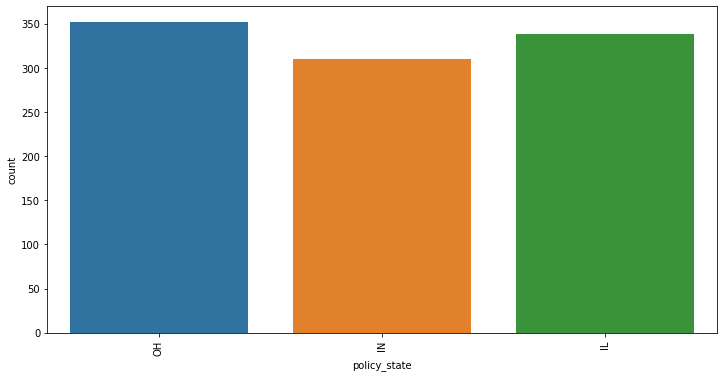

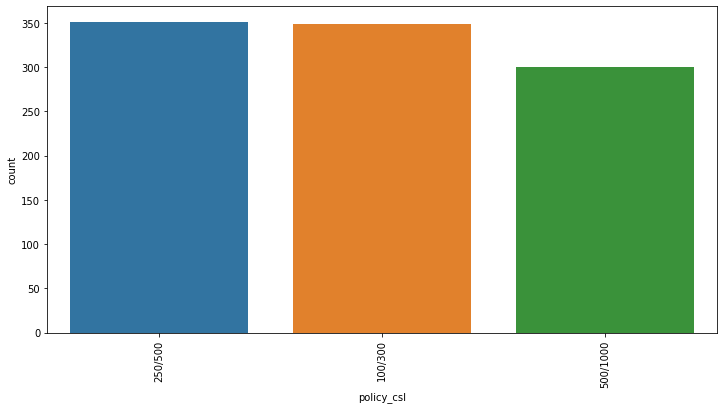

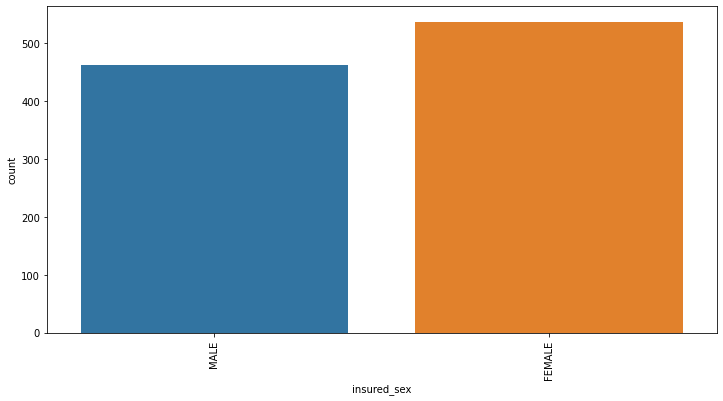

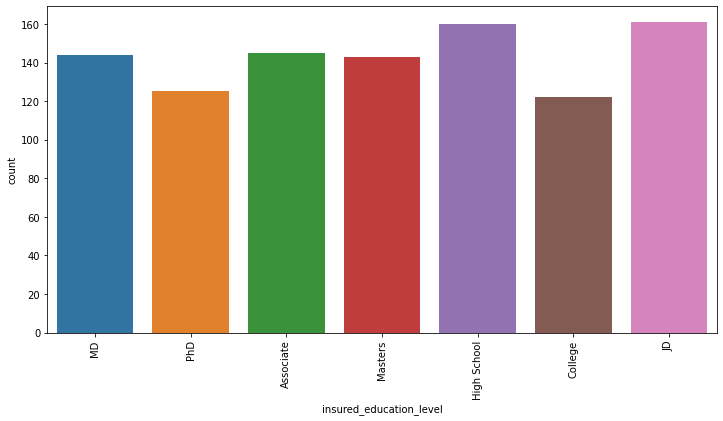

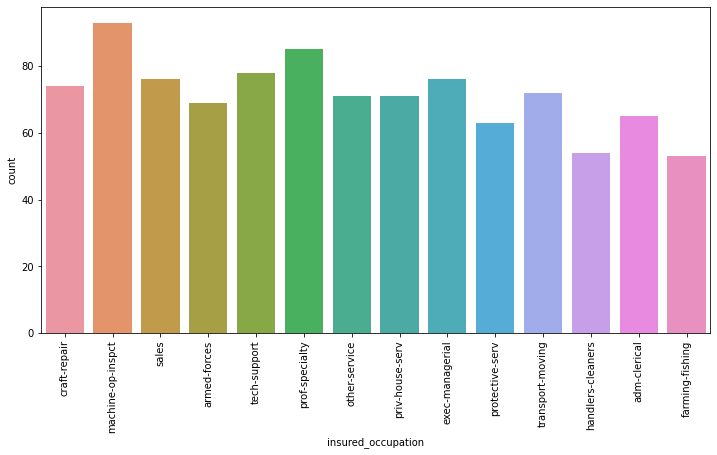

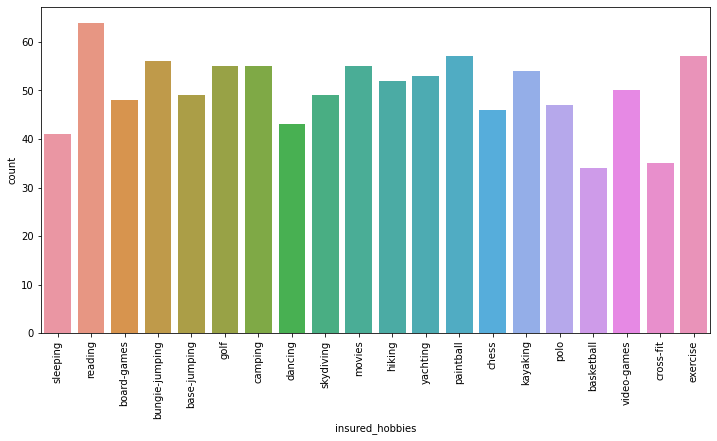

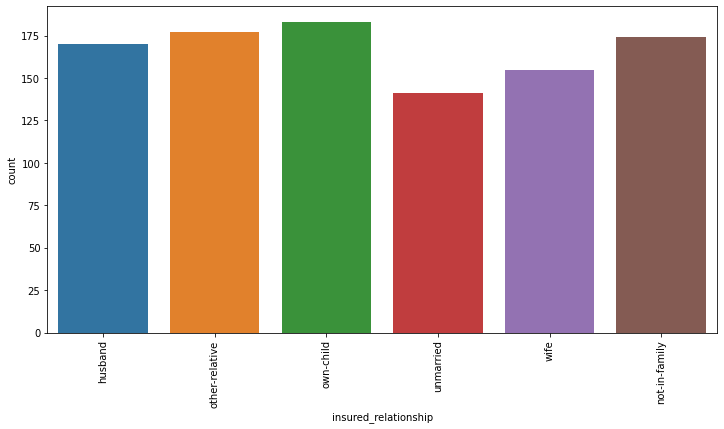

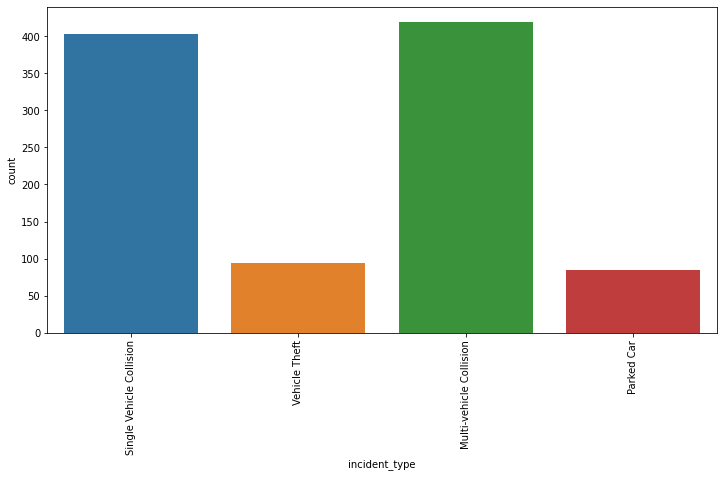

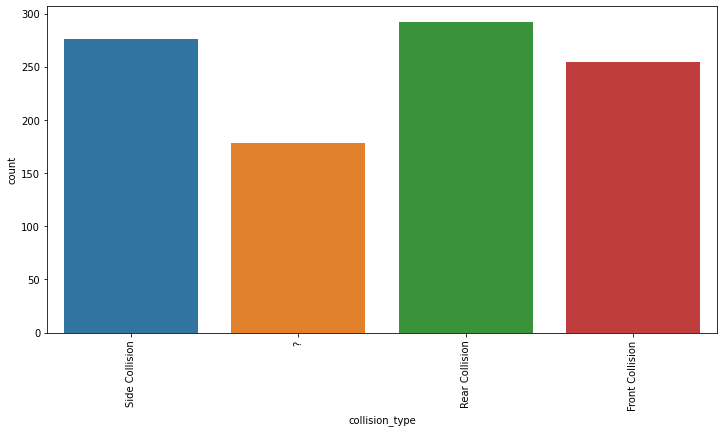

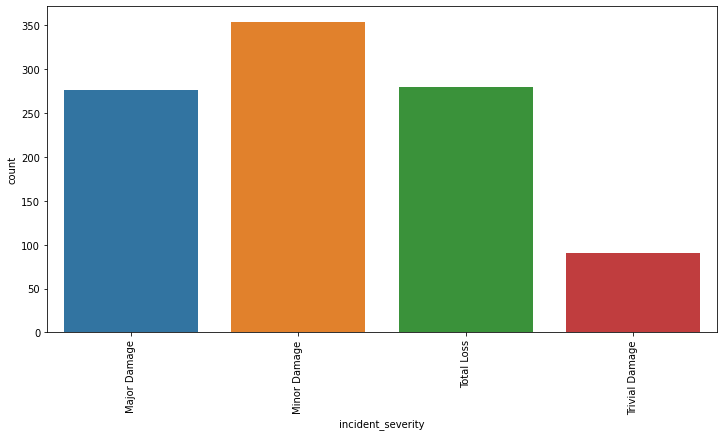

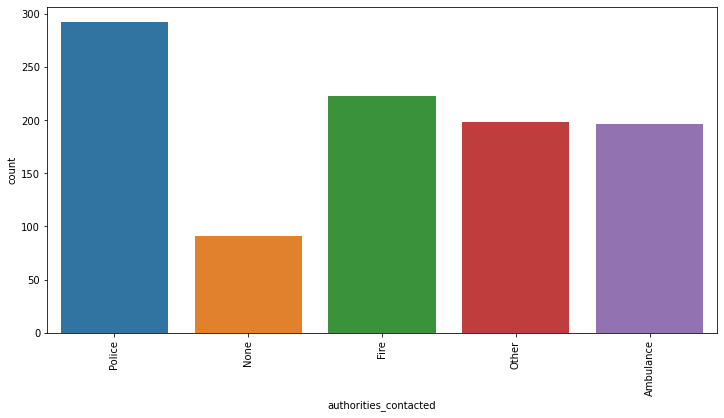

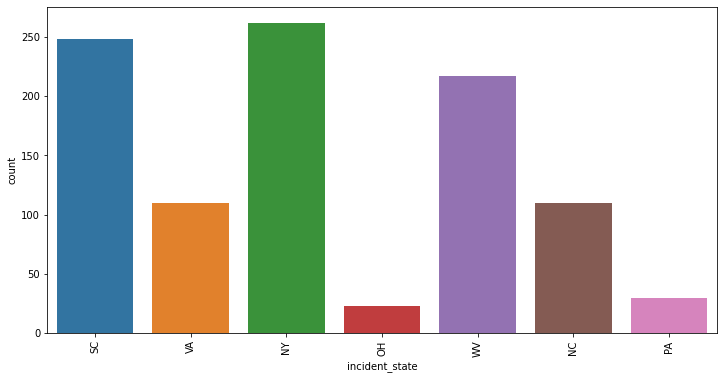

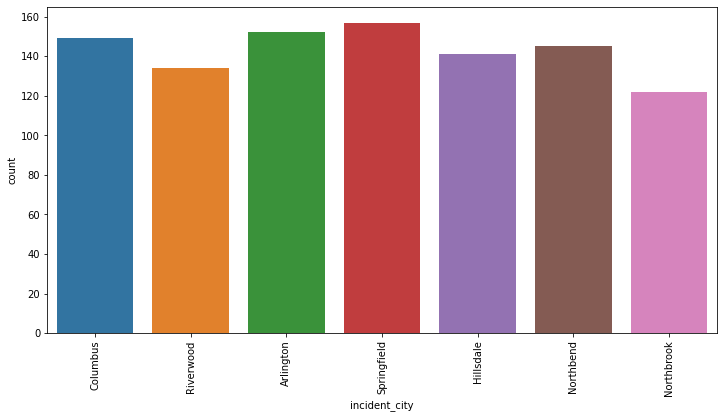

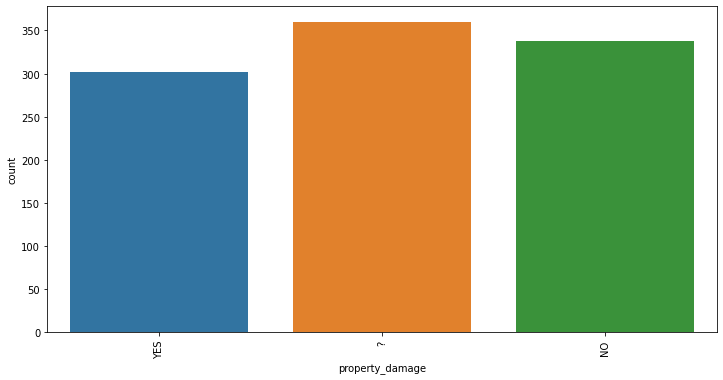

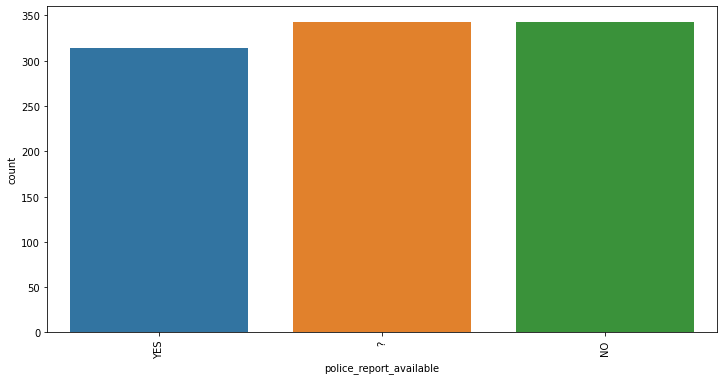

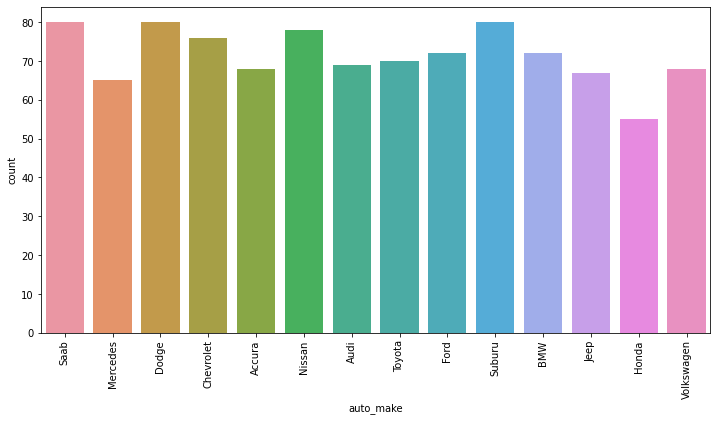

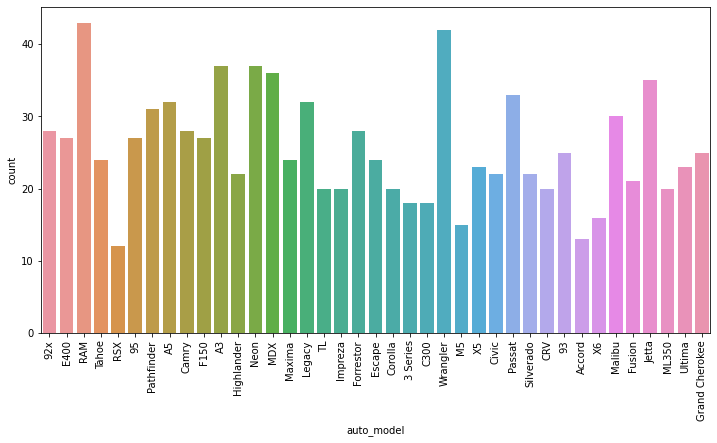

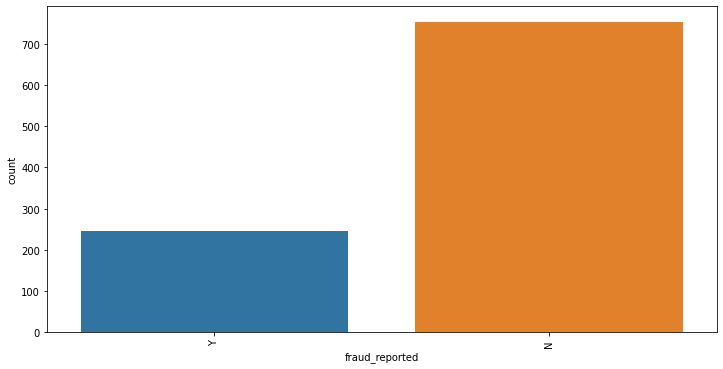

In [8]:
df_catagory = df.select_dtypes(include=['object'])
for col in df_catagory:
  if len(df_catagory[col].value_counts()) < 50:
    plt.figure(figsize=(12,6))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)

From reviewing the above plots, I will mention some of the observations:

* police_report_available, property_damage and collision_type have some unknowns labelled as '?'. We could remove these. Let's check their relationship with our target fraud_reported.
* fraud_reported, our target variable, is unbalanced where more than 75% of cases are no fraud. This value may be a good benchmark for our models. This unbalanced target will make models biased if not handled.

Now we will look at how often categories occur with fraud_reported

In [9]:
df_catagory['fraud_binary'] = df_catagory['fraud_reported'].map(dict(Y=1, N=0))
for col in df_catagory:
    count_df = df_catagory.groupby([col]).agg({'fraud_binary': 'mean', 'fraud_reported':'count' })
    count_df.columns = ['Fraud Rate', '# Claims']
    print(count_df.sort_values(by='Fraud Rate',ascending=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


              Fraud Rate  # Claims
policy_state                      
OH              0.258523       352
IN              0.254839       310
IL              0.227811       338
            Fraud Rate  # Claims
policy_csl                      
250/500       0.262108       351
100/300       0.257880       349
500/1000      0.216667       300
             Fraud Rate  # Claims
insured_sex                      
MALE           0.261339       463
FEMALE         0.234637       537
                         Fraud Rate  # Claims
insured_education_level                      
PhD                        0.264000       125
MD                         0.263889       144
College                    0.262295       122
JD                         0.260870       161
Associate                  0.234483       145
High School                0.225000       160
Masters                    0.223776       143
                    Fraud Rate  # Claims
insured_occupation                      
exec-managerial       0.3684

The above tables give us some interesting insight into what labels may most often occur with fraud.

Some standouts are:
* Chess & CrossFit hobbists have an unusual number of fraudulent claims
* Major Damage has the highest proportion of fraudulent claims out of all damage.
* X6, Silverado and ML350 have the highest proportion of fraudulent claims out of all models
* The state of OH has a high proportion of fraudulent cases

Note: for the whole dataset the number of fraudulent cases is 247/1000 which is about 0.247 so a category with a rate significantly higher than this may be worth investigating.

With police_report_available and property_damage we saw slightly more fraudulent cases when these values were '?'.

#The Models

That's enough data exploration for now. Let's use our findings to clean our data, set up a pipeline to encode categories and apply some preprocessing.

* For encoding, we will use One Hot Encoding for all the categories. Since most categories have no inherent order. They are Nominal categories.

* We will apply a standard scaler to all our numerical variables to reduce sensitivity to large values.

The models we will investigate will be:

* Random Forest
* Decision Trees
* XGB - Extreme Gradient Boosting

We will set up our categorical features and numerical features. Then we will split our data into a training and test set.

In [10]:
#train test splitter and grid search
from sklearn.model_selection import train_test_split, GridSearchCV

cata_feat = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 
       'police_report_available', 'auto_make', 'auto_model']

numeric_feat = ['age',  'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'capital-gains', 'capital-loss', 
                'incident_hour_of_the_day','number_of_vehicles_involved', 'bodily_injuries','witnesses', 
                'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year' ]

label = ['fraud_reported']
features = numeric_feat + cata_feat
X = df[features]
y = df[label]

#split our test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


Here we set up our preprocess transformers as mentioned earlier.
Simply put will scale our numerical data and one hot encode our categorical.

Then we will bundle that all into a column transformer. This will be our preprocessor.

In [11]:
#preprocess steps
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#pipline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

numeric_trans = Pipeline([ 
                          ('scaler', StandardScaler()), 
])

cata_trans = OneHotEncoder() 

#bundle our preprocessers together
preprocessor = ColumnTransformer([
                                  ('num', numeric_trans, numeric_feat),
                                  ('cat', cata_trans, cata_feat),
])



Below I have made a handy function we can use to generalise our model running process.  All we need to do is pass our model, the preprocessor and some hyper parameters.

This function will then run a 5-fold CV grid search of those parameters and give us the best working model out of the fits

Finally, it will return some performance metrics but more on that later.

In [12]:
# performace analysers
from sklearn.metrics import confusion_matrix, classification_report

def run_model_and_evaluate(model, preprocessor, param_grid):
  #pipleine it all together with a model
  pipe = Pipeline([
                    ('preprocess', preprocessor),
                    ('clf', model) #this is our imbalance handler
  ])

  #fit and score the model
  cv = GridSearchCV( pipe, param_grid, n_jobs=-1, cv=5, verbose=10)
  cv.fit(X_train, y_train.values.ravel())

  rf_best_score_train = cv.best_score_
  rf_best_score_test = cv.best_estimator_.score(X_test, y_test)
  rf_cm = confusion_matrix(y_test, cv.predict(X_test))
  rf_score_detail = classification_report(y_test, cv.predict(X_test))

  print('The best score on training was: ', rf_best_score_train, 
        'The best score on test was: ', rf_best_score_test, 
        'With the following confusion matrix', rf_cm,
        'And the following precision and recall', rf_score_detail,
        'with the following parameters.', cv.best_params_ , sep='\n')
  
  return ([rf_best_score_train, rf_best_score_test, rf_cm, rf_score_detail])


## DecisionTreeClassifier

As seen below, we got an accuracy of about 78.5% in our test data. That's not as good as guessing the most common class (not fraud) 160/200 = 80%.
We also got a recall of 75% which means of the 40 fraudulent cases in the test-set
this model detected 30 of them. That's a whole lot better than guessing the most common class which would have been 0%

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree_results = run_model_and_evaluate(DecisionTreeClassifier(class_weight='balanced', random_state=101),
                                    preprocessor,
                                    param_grid = {
                                        'clf__criterion':['gini','entropy'],
                                        'clf__max_depth':[16,32,64],
                                        }
                                    )

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best score on training was: 
0.7875
The best score on test was: 
0.785
With the following confusion matrix
[[127  33]
 [ 10  30]]
And the following precision and recall
              precision    recall  f1-score   support

           N       0.93      0.79      0.86       160
           Y       0.48      0.75      0.58        40

    accuracy                           0.79       200
   macro avg       0.70      0.77      0.72       200
weighted avg       0.84      0.79      0.80       200

with the following parameters.
{'clf__criterion': 'gini', 'clf__max_depth': 16}


## RandomForestClassifier

As seen below, we got an accuracy of about 83.5% in our classification of the test-set.
We also got a recall if 85% meaning of the 40 fraudulent cases in the test-set
this model detected 34 of them. 

The Random Forest did better here than our benchmark accuracy of 80% and its recall improved on the decision tree.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_results = run_model_and_evaluate(RandomForestClassifier(class_weight='balanced', random_state=101),
                                    preprocessor,
                                    param_grid = {
                                        "clf__n_estimators": [100, 300],
                                        "clf__criterion": ['entropy'],
                                        "clf__max_depth": [8, 16],
                                        'clf__max_leaf_nodes': [8, 16]
                                        }
                                    )

Fitting 5 folds for each of 8 candidates, totalling 40 fits
The best score on training was: 
0.835
The best score on test was: 
0.835
With the following confusion matrix
[[133  27]
 [  6  34]]
And the following precision and recall
              precision    recall  f1-score   support

           N       0.96      0.83      0.89       160
           Y       0.56      0.85      0.67        40

    accuracy                           0.83       200
   macro avg       0.76      0.84      0.78       200
weighted avg       0.88      0.83      0.85       200

with the following parameters.
{'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_leaf_nodes': 8, 'clf__n_estimators': 300}


## XGBClassifier

As seen below, we got an accuracy of about 81.5% in our classification of the test-set.
We also got a recall if 62% meaning of the 40 fraudulent cases in the test-set
this model detected 25 of them.

XGB beat the benchmark but its recall was the worst of the bunch.

In [15]:
from xgboost import XGBClassifier

#we need this so we can tell XGB weight since our target is unbalanced
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train[label]
)

xgb_results = run_model_and_evaluate(XGBClassifier(sample_weight=classes_weights, random_state=101) ,
                                    preprocessor,
                                    param_grid = {
                                        'clf__n_estimators':[100,300],
                                        'clf__max_depth':[8, 16],
                                        'clf__eta':[0.025,0.05,0.1] 
                                        }
                                    )

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best score on training was: 
0.82875
The best score on test was: 
0.815
With the following confusion matrix
[[138  22]
 [ 15  25]]
And the following precision and recall
              precision    recall  f1-score   support

           N       0.90      0.86      0.88       160
           Y       0.53      0.62      0.57        40

    accuracy                           0.81       200
   macro avg       0.72      0.74      0.73       200
weighted avg       0.83      0.81      0.82       200

with the following parameters.
{'clf__eta': 0.025, 'clf__max_depth': 16, 'clf__n_estimators': 100}


In [16]:
models = pd.DataFrame({
    'Model' : ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Train_Score' : [tree_results[0], rf_results[0], xgb_results[0]],
    'Test_Score' : [tree_results[1], rf_results[1], xgb_results[1]] ,
    'Recall': [tree_results[2][1,1]/(tree_results[2][1,1]+tree_results[2][1,0]), 
               rf_results[2][1,1]/(rf_results[2][1,1]+rf_results[2][1,0]), 
               xgb_results[2][1,1]/(xgb_results[2][1,1]+xgb_results[2][1,0])] 
})

In [17]:
import plotly.express as px

fig = px.bar(models, x=["Train_Score",'Test_Score','Recall'], y="Model", barmode = 'group')
   
fig.show()

#Conclusion

As seen above, the Random Forest model performed the best of all.

I focused on recall as a driving metric over accuracy since when fraud occurs you would rather risk falsely labelling an event as a fraud than miss true fraud events.

We did not explore in too much detail to see if the model is overfitting since the test and train results were not vastly different. We can be somewhat confident this is not the case. However, if we wanted to test for overfitting more rigorously, we could randomly sample new data to run predictions on and see if the accuracy falls away.

Further extensions would be:
* give the models more trees/depth and see if that improves performance
* testing other classification models to see if they perform better
* introduce embedded and wrapper feature selection methods to see if accuracy is improved, such as, RFE or PCA
* visualise what features were deemed most important for the model
* cluster the data using SVM/PCA or TSNE and see if any groups form